<a href="https://colab.research.google.com/github/porto-o/eda-news-gdelt/blob/main/EDA_News_tt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

from google.colab import userdata

BASE_PATH = userdata.get('BASE_PATH')

In [20]:
# @title
def boxplot(df_copy):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # char
    sns.boxplot(x=df_copy['title_length'], color='skyblue', ax=axes[0])
    axes[0].set_title('Distribución de longitud de títulos', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Longitud (caracteres)')
    axes[0].set_ylabel('')

    # words
    sns.boxplot(x=df_copy['word_count'], color='lightgreen', ax=axes[1])
    axes[1].set_title('Distribución de número de palabras', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Número de palabras')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()


In [21]:
# @title
import matplotlib.pyplot as plt
import numpy as np

def plot_pareto(df_counts: pd.DataFrame, col_name: str = 'domain'):
    df_sorted = df_counts.sort_values('count', ascending=False)

    counts = df_sorted['count']
    categories = df_sorted.index.astype(str)

    # Cálculo acumulado en porcentaje
    cumulative_percentage = counts.cumsum() / counts.sum() * 100

    # Ubicación donde se alcanza el 80%
    cutoff_idx = np.argmax(cumulative_percentage >= 80)

    fig, ax1 = plt.subplots(figsize=(10,6))

    ax1.bar(categories, counts, color='skyblue')
    ax1.set_ylabel('Conteo', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticklabels(categories, rotation=45, ha='right')

    # Línea de acumulado porcentual
    ax2 = ax1.twinx()
    ax2.plot(categories, cumulative_percentage, color='red', marker='o', linestyle='-', linewidth=2)
    ax2.set_ylabel('Acumulado %', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.axhline(80, color='green', linestyle='--', linewidth=1)

    # Marca vertical del corte 80%
    ax2.axvline(cutoff_idx, color='purple', linestyle='--', linewidth=1)

    plt.title(f'Pareto de {col_name}' if col_name else 'Gráfico de Pareto')
    plt.tight_layout()
    plt.show()


# Análisis exploratorio de noticias

- [X] Conteo de duplicados por `conjunto`
- [X] Métricas de longitudes de los titulares (por caractéres y palabras)
- [X] Palabras más repetidas, 1-grama y n-gramas *
- [X] Proporción de dominios

In [22]:
def compound_duplicates(df: pd.DataFrame, subset=['title', 'seendate', 'domain']):
  """
    Show the total duplicates on df based on subset,}
    along with the proportion.
  """
  total_dup = df.duplicated(subset=subset).sum()
  perc = (total_dup * 100) / df.shape[0]

  print("\n" + "=" * 90)
  print("DUPLICADOS EN CONJUNTO".center(90))
  print("=" * 90)
  print(f"\nColumnas evaluadas: {subset}")
  print(f"Total de duplicados: {total_dup:,}")
  print(f"Proporción: {perc:.2f}% del total ({df.shape[0]:,} filas)\n")
  print("*" * 90 + "\n")

In [23]:
def stats_titles(df: pd.DataFrame, text_col='title', show_charts: bool = False):
    df_copy = df.copy()
    titles = df_copy[text_col].dropna().astype(str)

    df_copy['title_length'] = titles.apply(len)
    df_copy['word_count'] = titles.apply(lambda x: len(x.split()))

    print("\n" + "="*90)
    print("ANÁLISIS DE TITULARES".center(90))
    print("="*90)

    print("-"*90)
    print("MÉTRICAS POR CARACTERES")
    print("-"*90)
    print(df_copy['title_length'].describe().to_string())

    print("\n" + "-"*90)
    print("MÉTRICAS POR PALABRAS")
    print("-"*90)
    print(df_copy['word_count'].describe().to_string())

    if show_charts:
        print("\n" + "-"*90)
        print("GRÁFICAS")
        print("-"*90)
        boxplot(df_copy)

    print("\n" + "-"*90)
    print("EJEMPLOS")
    print("-"*90)
    shortest_title = df_copy.loc[df_copy['title_length'].idxmin(), text_col]
    longest_title = df_copy.loc[df_copy['title_length'].idxmax(), text_col]

    print("Título más corto:\n" + shortest_title)
    print("\nTítulo más largo:\n" + longest_title)
    print("*"*90 + "\n")

In [24]:
def cat_col_analysis(df: pd.DataFrame, col: str = 'domain'):
    df_copy = df.copy()

    counts = df_copy[col].value_counts(dropna=False)
    proportion = df_copy[col].value_counts(normalize=True, dropna=False) * 100

    result = pd.DataFrame({
        'count': counts,
        'percentage': proportion
    })

    print("\n" + "="*90)
    print(f"ANÁLISIS DE COLUMNA: {col.upper()}".center(90))
    print("="*90)

    print("-"*90)
    print("CONTEO Y PORCENTAJE POR CATEGORÍA")
    print("-"*90)
    print(result.to_string())

    print("\n" + "-"*90)
    print("EJEMPLOS DE CATEGORÍAS")
    print("-"*90)
    print("Categoría más frecuente:", counts.idxmax())
    print("Categoría menos frecuente:", counts.idxmin())
    print("*"*90 + "\n")

    plot_pareto(result, col_name=col)

In [44]:
def top_ngrams(df, text_col='title', n=20, ngram_range=(2,5), min_df=1, show_examples=3):
    """
    Muestra las palabras o n-gramas más frecuentes en una columna de texto.

    Args:
        df: DataFrame con la columna de texto
        text_col: columna de texto a analizar
        n: cantidad de n-gramas a mostrar
        ngram_range: rango de n-gramas (min_n, max_n)
        min_df: mínimo número de documentos donde aparece el n-grama
        show_examples: cuántos ejemplos mostrar
    """
    texts = df[text_col].dropna().astype(str)
    vectorizer = CountVectorizer(ngram_range=ngram_range, min_df=min_df)
    X = vectorizer.fit_transform(texts)

    freqs = X.sum(axis=0).A1
    terms = vectorizer.get_feature_names_out()

    df_freq = pd.DataFrame({'ngram': terms, 'count': freqs}).sort_values('count', ascending=False)

    print("\n" + "="*90)
    print(f"TOP {n} {'PALABRAS' if ngram_range==(1,1) else f'{ngram_range[0]}-{ngram_range[1]} GRAMAS'} EN '{text_col.upper()}'".center(90))
    print("="*90)
    print(df_freq.head(n).to_string(index=False))

    print("\n" + "-"*90)
    print(f"EJEMPLOS DE N-GRAMAS MÁS FRECUENTES ({show_examples})")
    print("-"*90)
    for _, row in df_freq.head(show_examples).iterrows():
        print(f"{row['ngram']}: {row['count']} veces")
    print("*"*90 + "\n")

    return df_freq.head(n)


In [45]:
def start_analysis(country="mexico"):
  path = f'{BASE_PATH}/base_clean_{country}.csv'

  df = pd.read_csv(f'{path}')

  print("#"*10, f'{country.upper()}', "#"*10)

  # Duplicados en conjunto
  compound_duplicates(df)

  # Métricas de titulos
  stats_titles(df=df, show_charts=True)

  # Dominios
  cat_col_analysis(df)

  # Palabras freq
  top_ngrams(df)

  # Languages
  #cat_col_analysis(df, 'language')

########## BRASIL ##########

                                  DUPLICADOS EN CONJUNTO                                  

Columnas evaluadas: ['title', 'seendate', 'domain']
Total de duplicados: 122
Proporción: 0.21% del total (59,089 filas)

******************************************************************************************


                                  ANÁLISIS DE TITULARES                                   
------------------------------------------------------------------------------------------
MÉTRICAS POR CARACTERES
------------------------------------------------------------------------------------------
count    59089.000000
mean        77.509841
std         20.195909
min          6.000000
25%         65.000000
50%         76.000000
75%         90.000000
max        253.000000

------------------------------------------------------------------------------------------
MÉTRICAS POR PALABRAS
-----------------------------------------------------------------------------

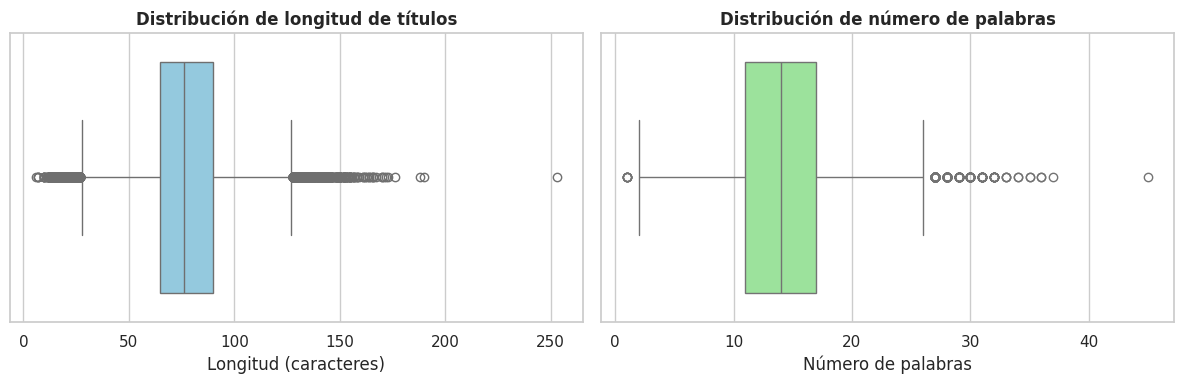


------------------------------------------------------------------------------------------
EJEMPLOS
------------------------------------------------------------------------------------------
Título más corto:
Arthur

Título más largo:
A campanha do democrata Joe Biden reagiu à declarao do presidente Donald Trump , após o republicano anunciar que irá pedir à Suprema Corte que a contagem dos votos da eleio seja paralisada .  Ultrajante , sem precedentes e incorreto , disse a chefe d...
******************************************************************************************


                               ANÁLISIS DE COLUMNA: DOMAIN                                
------------------------------------------------------------------------------------------
CONTEO Y PORCENTAJE POR CATEGORÍA
------------------------------------------------------------------------------------------
                        count  percentage
domain                                   
g1.globo.com            10

/tmp/ipython-input-786532418.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(categories, rotation=45, ha='right')


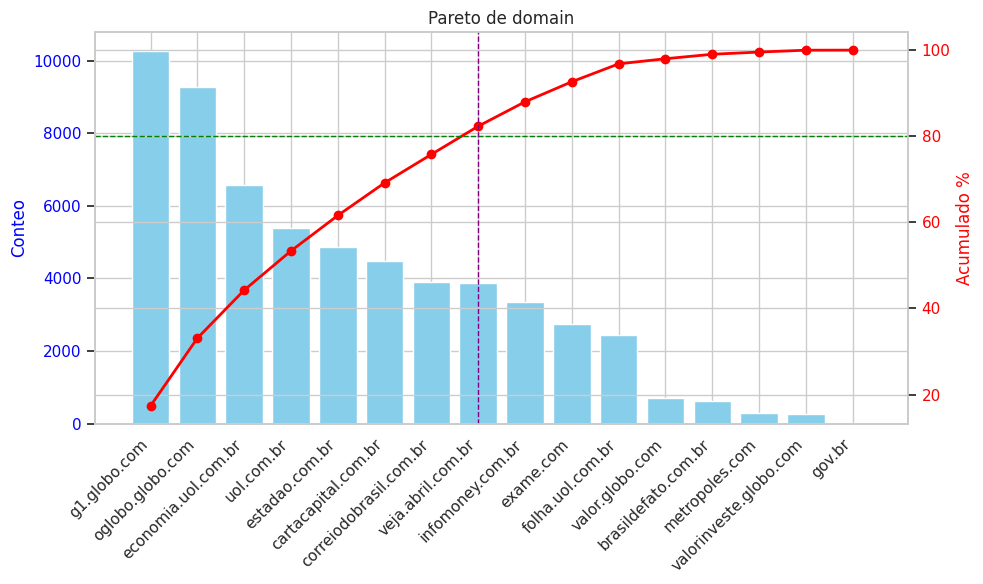


                               TOP 20 2-5 GRAMAS EN 'TITLE'                               
            ngram  count
        do brasil   1783
          diz que   1560
       correio do   1385
correio do brasil   1385
          nos eua    982
        no brasil    887
          mais de    868
     de bolsonaro    864
          dos eua    853
          por que    812
         de juros    723
         covid 19    604
          de lula    566
         de trump    520
       do governo    487
            de sp    467
           do rio    446
     2025 mercado    443
    presidente do    435
    banco central    425

------------------------------------------------------------------------------------------
EJEMPLOS DE N-GRAMAS MÁS FRECUENTES (3)
------------------------------------------------------------------------------------------
do brasil: 1783 veces
diz que: 1560 veces
correio do: 1385 veces
******************************************************************************************



In [46]:
start_analysis('brasil')